In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms
from tqdm.auto import tqdm
import pickle
import sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler

In [2]:
#edited from Yang's code
def umap_visualizations():
    # Load features
    with open('./midog_clip_features_patches.pkl', 'rb') as f:
        features_dict = pickle.load(f)

    #load metadata from csv file
    metadata_df = pd.read_csv('midog.csv')
    metadata_df.columns = metadata_df.columns.str.strip()
    metadata_df['Slide'] = metadata_df['Slide'].astype(str).str.strip()
    train_metadata_df = metadata_df[metadata_df['Dataset'] == 'train'].copy() #get only the training
    
    all_features = []
    all_filenames = []
    slide_numbers = []

    #get the slide numbers from filenames to merge with metadata
    # Extract slide numbers from filenames (e.g., '034.tiff' -> '34')
    for filename, data in features_dict.items():
        base_name = Path(filename).stem #remove the file extension
        try:
            slide_num = str(int(base_name)) #convert to int then string to remove leading zeros
        except ValueError:
            slide_num = base_name #keep original if it does not work
        
        # Only include features from training slides
        if slide_num in train_metadata_df['Slide'].values:
            features = data['features'] #feature vectors for image
            all_features.extend(features)
            all_filenames.extend([filename]*len(features)) #repeat filename for each patch
            slide_numbers.extend([slide_num]*len(features))

    feature_array = np.array(all_features)

    # UMAP embedding
    #standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_array)
    
    #I just followed the same parameter as Yang
    umap_model = umap.UMAP(
        n_neighbors=15, 
        n_components=2, #we reduce to 2 dimensions
        min_dist=0.1, #how close clusters are
        metric='cosine', #distance metric (I think cosine is better for high dimensional data)
        random_state=42
    )
    embedding = umap_model.fit_transform(features_scaled)
    
    #DataFrame with embeddings and metadata
    embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    embedding_df['filename'] = all_filenames
    embedding_df['Slide'] = slide_numbers
    
    #merge with metadata
    final_df = embedding_df.merge(metadata_df[['Slide', 'Dataset', 'Tumor', 'Scanner', 'Origin', 'Species']], 
                                  on='Slide',
                                  how='inner') #inner join to ensure only training data remains
    
    #visualizations for each category
    categories = ['Slide', 'Tumor', 'Scanner', 'Origin', 'Species']

    #following Yang's code for plotting
    for category in categories:
        plt.figure(figsize=(14, 10)) #new figure for each category 
        
        unique_values = sorted(final_df[category].dropna().unique()) #get unique values for this category
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_values))) # getdistinct colors for each value
        
        for value, color in zip(unique_values, colors): #plot each group with a different color
            mask = final_df[category] == value #boolean mask for this to select patches with specific value
            plt.scatter(
                final_df.loc[mask, 'UMAP1'],
                final_df.loc[mask, 'UMAP2'],
                label=str(value),
                color=color,
                s=60,
                alpha=0.7,
                edgecolors='white',
                linewidth=0.5,
            )
        
        plt.title(f'UMAP Projection of Features, Colored by {category}', fontsize=16, pad=20)
        plt.xlabel('UMAP Component 1', fontsize=14)
        plt.ylabel('UMAP Component 2', fontsize=14)
        if category != 'Slide':
            plt.legend(title=category, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        #plt.savefig(f'umap_{category.lower()}_patches.png', dpi=300, bbox_inches='tight')
    return final_df


/home/caoyang/.local/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


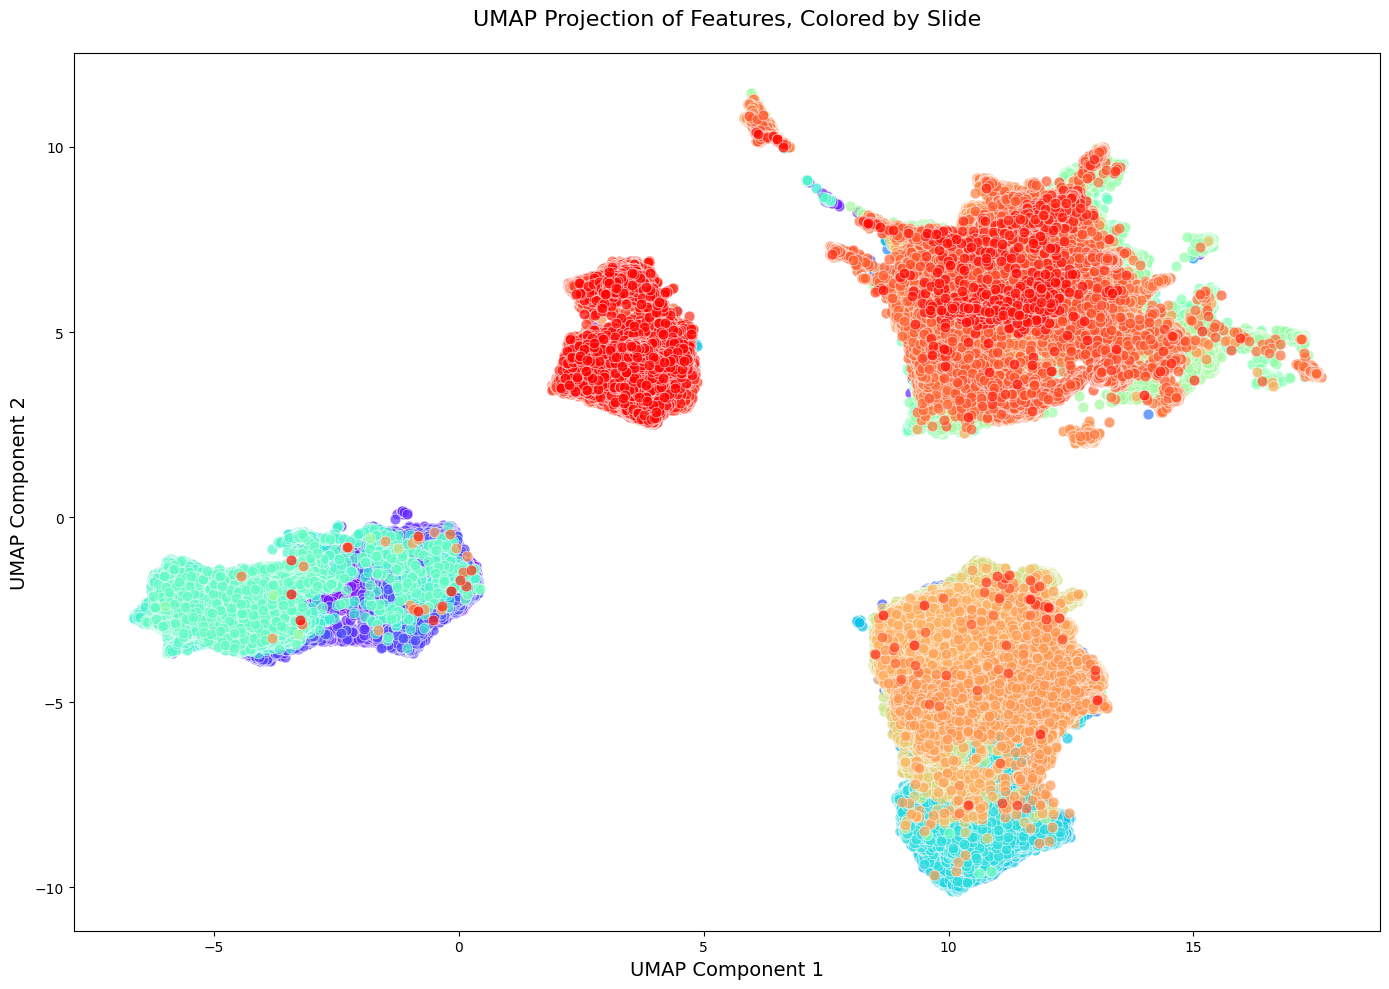

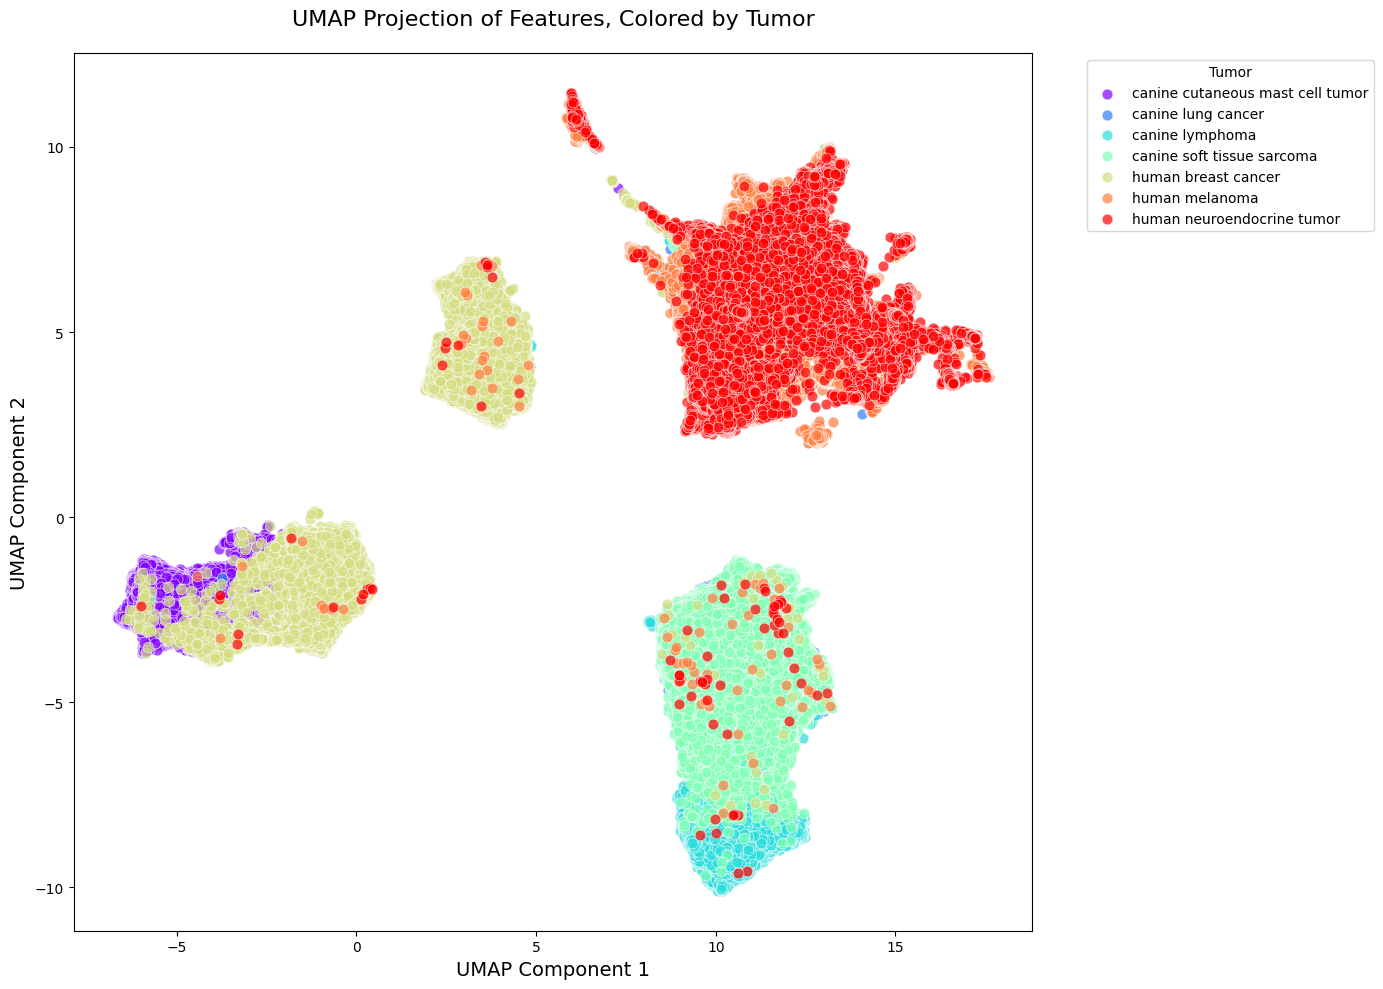

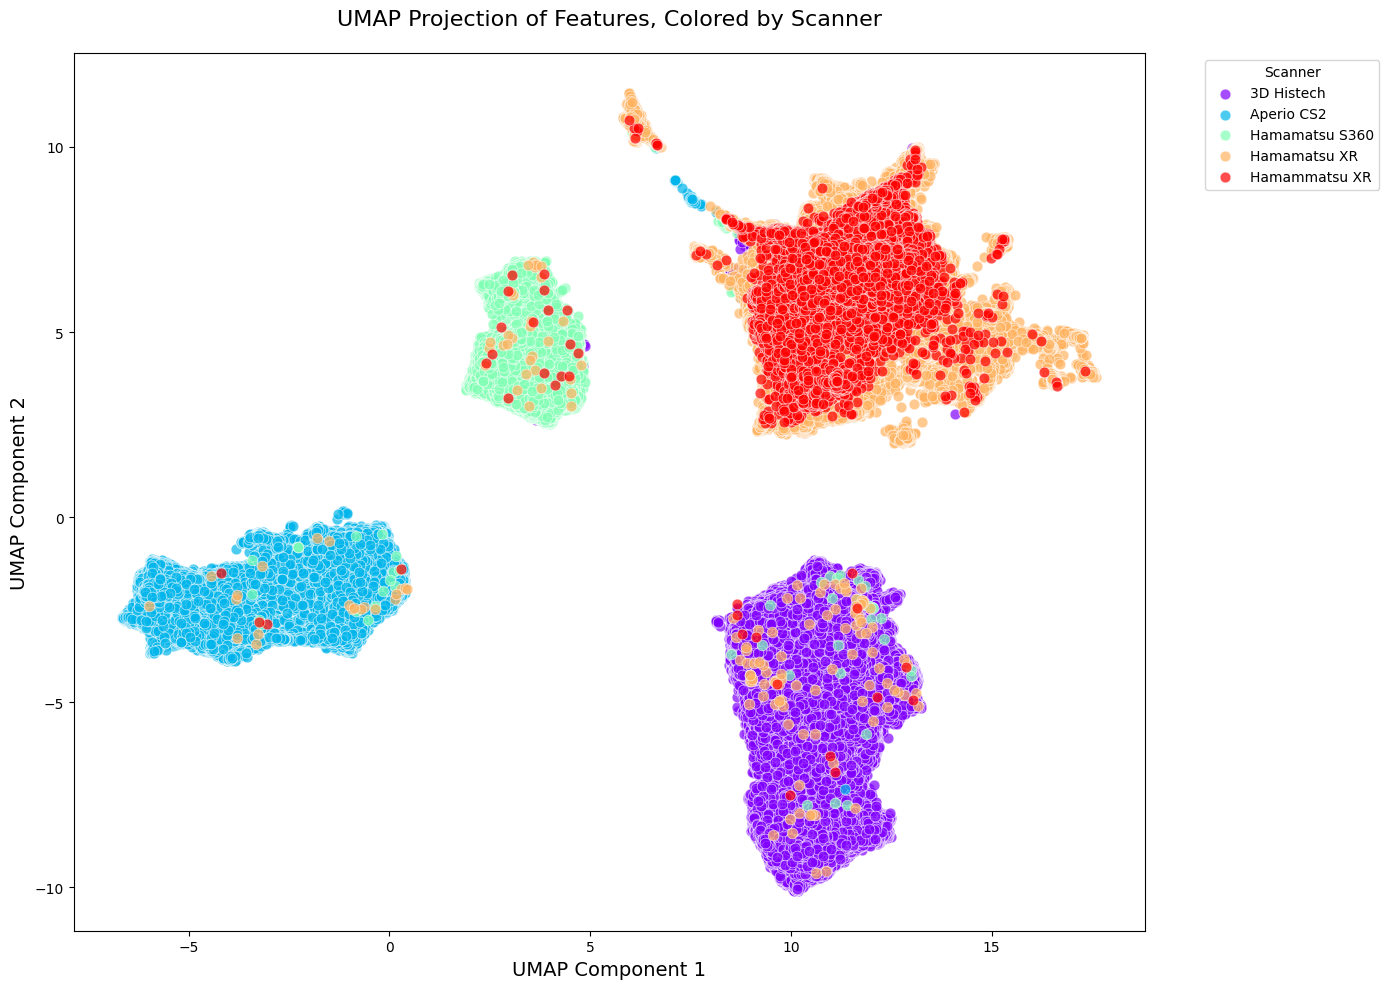

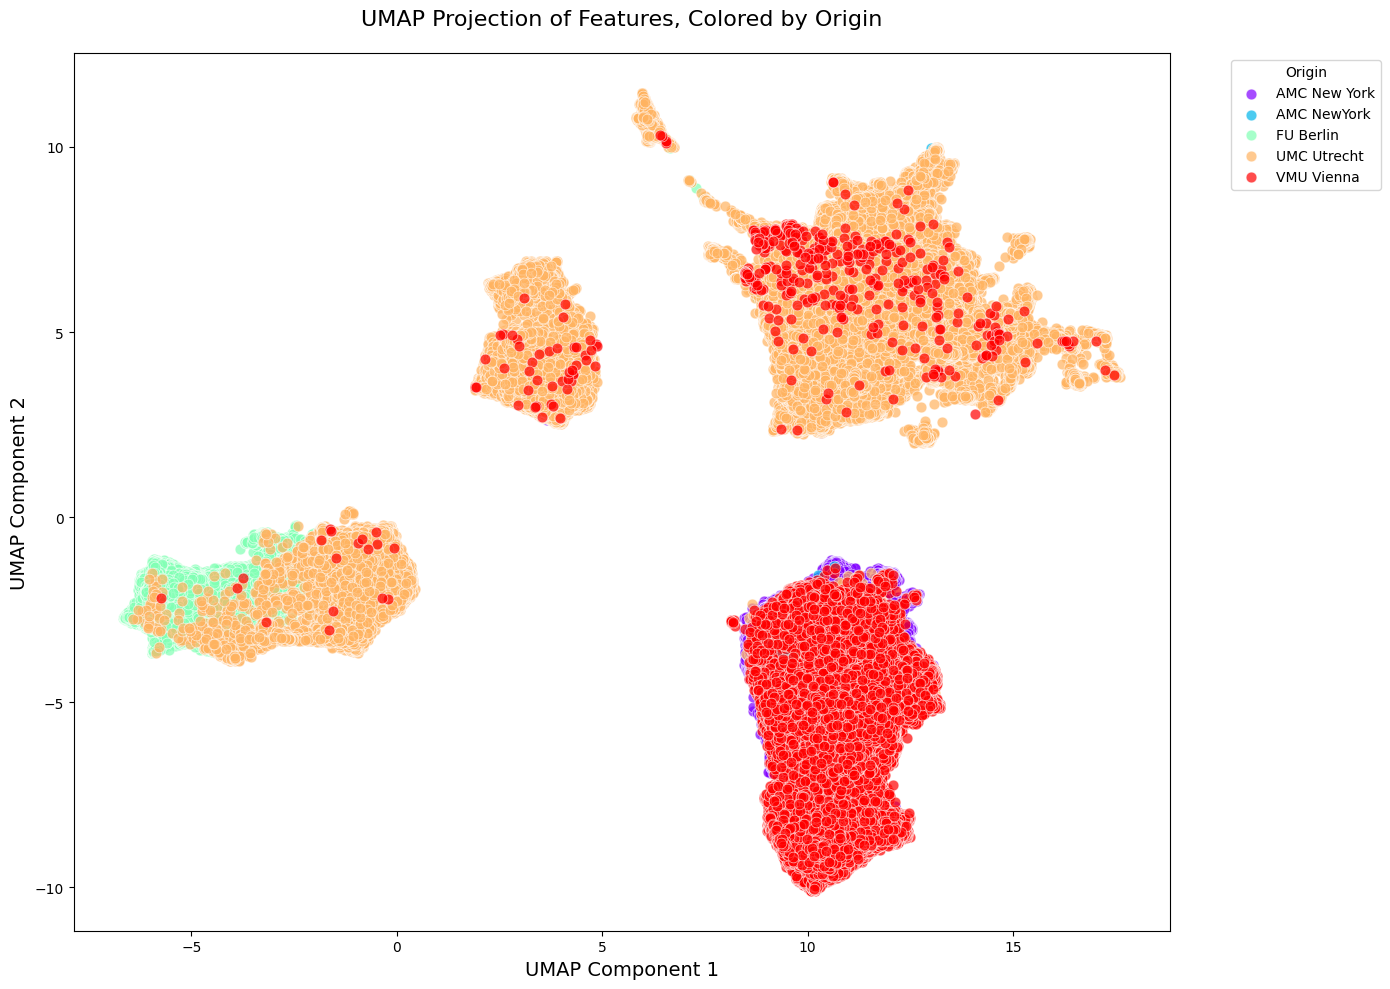

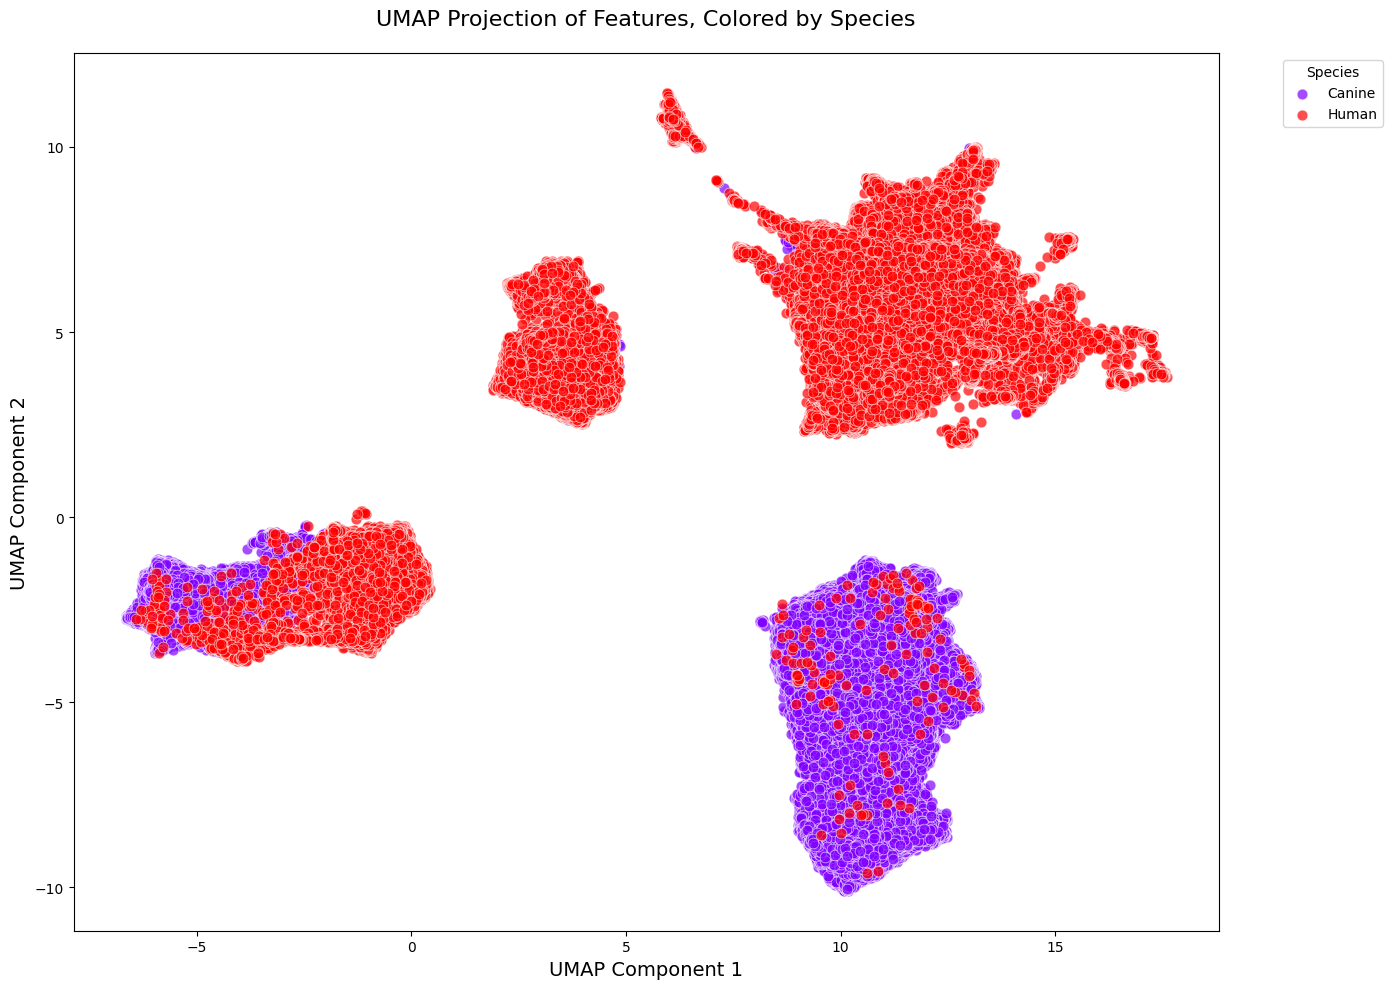

In [3]:
#UMAP analysis
results_df = umap_visualizations()
results_df.to_csv('umap_results_with_metadata_clip.csv', index=False)